In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=9fb1c60dd4758f6717eff88dc29809954bdaf5292959ca220a4fbccd4f4ee1ce
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


## **3. N-gram Analysis**
Business Value: Identifying common phrases and keywords in reviews can help in crafting more effective marketing messages. For instance, if many reviews mention "unexpected plot twist" as a positive aspect, this can be highlighted in promotional materials. N-gram analysis also aids in understanding the language customers use, allowing for better communication and marketing alignment.

Identifying customers who prefer certain genres can also help in curating tailored book collections or subscription boxes.; give me a suitable code for this

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import NGram
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.rdd import RDD

# Initialize SparkSession
spark = SparkSession.builder.appName("NGramAnalysis").getOrCreate()

# Load CSV into DataFrame
df_reviews_with_sentiment = spark.read.csv("/kaggle/input/reviews-with-sentiment-for-trigram", 
                                          header=True, inferSchema=True)
df_reviews_with_sentiment.show(5) 

+--------------------+-----+------------+-------------------------+----------------------+---------------+------------------------+
|               Title|Price|review/score|Lemmatized review/summary|Lemmatized review/text|Sentiment_Score|Sentiment_Category_VADER|
+--------------------+-----+------------+-------------------------+----------------------+---------------+------------------------+
|Its Only Art If I...| NULL|         4.0|     nice collection j...|  julie strain fans...|         0.9481|                  Better|
|Dr. Seuss: Americ...| NULL|         5.0|             really enjoy|  do not care much ...|          0.984|                  Better|
|Dr. Seuss: Americ...| NULL|         5.0|     essential every p...|  people become boo...|         0.9911|                  Better|
|Dr. Seuss: Americ...| NULL|         4.0|     phlip nel give si...|  theodore seuss ge...|         0.9678|                  Better|
|Dr. Seuss: Americ...| NULL|         4.0|     good academic ove...|  philip 

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re
from nltk.corpus import stopwords

# Load stopwords
stop_words = set(stopwords.words('english'))

# Define preprocessing function for LDA
def preprocess_for_lda(text):
    # Handle non-string entries by converting to empty string if necessary
    if not isinstance(text, str):
        text = ''
    
    # Tokenize and remove stopwords
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Optionally, clean tokens further (remove punctuation, etc.)
    tokens = [re.sub(r'\W+', '', token) for token in tokens]  # Remove special characters
    return tokens

# Register the function as a UDF
preprocess_udf = udf(preprocess_for_lda, ArrayType(StringType()))

# Apply preprocessing using the UDF
df_reviews_with_sentiment = df_reviews_with_sentiment.withColumn('tokens', preprocess_udf(df_reviews_with_sentiment['Lemmatized review/summary']))

# Show the result
df_reviews_with_sentiment.select('Lemmatized review/summary', 'tokens').show(5, truncate=False)

+--------------------------------------------+----------------------------------------------------+
|Lemmatized review/summary                   |tokens                                              |
+--------------------------------------------+----------------------------------------------------+
|nice collection julie strain image          |[nice, collection, julie, strain, image]            |
|really enjoy                                |[really, enjoy]                                     |
|essential every personal public library     |[essential, every, personal, public, library]       |
|phlip nel give silly seuss serious treatment|[phlip, nel, give, silly, seuss, serious, treatment]|
|good academic overview                      |[good, academic, overview]                          |
+--------------------------------------------+----------------------------------------------------+
only showing top 5 rows



In [22]:
df_reviews_with_sentiment.show(5)

+--------------------+-----+------------+-------------------------+----------------------+---------------+------------------------+--------------------+
|               Title|Price|review/score|Lemmatized review/summary|Lemmatized review/text|Sentiment_Score|Sentiment_Category_VADER|              tokens|
+--------------------+-----+------------+-------------------------+----------------------+---------------+------------------------+--------------------+
|Its Only Art If I...| NULL|         4.0|     nice collection j...|  julie strain fans...|         0.9481|                  Better|[nice, collection...|
|Dr. Seuss: Americ...| NULL|         5.0|             really enjoy|  do not care much ...|          0.984|                  Better|     [really, enjoy]|
|Dr. Seuss: Americ...| NULL|         5.0|     essential every p...|  people become boo...|         0.9911|                  Better|[essential, every...|
|Dr. Seuss: Americ...| NULL|         4.0|     phlip nel give si...|  theodore seus

In [23]:
# Generate trigrams
ngram_transformer_trigram = NGram(n=3, inputCol="tokens", outputCol="trigrams")
df_trigrams = ngram_transformer_trigram.transform(df_reviews_with_sentiment)

In [25]:
def extract_ngrams(row, col_name):
    ngrams = row[col_name]
    if ngrams:
        return [(ngram, 1) for ngram in ngrams]
    else:
        return []

# Convert to RDD and extract trigrams from the DataFrame (replace `df_trigrams` with the actual DataFrame name you have)
trigrams_rdd = df_trigrams.rdd.flatMap(lambda row: extract_ngrams(row, "trigrams"))

# Count the frequency of trigrams
trigram_freq = trigrams_rdd.reduceByKey(lambda a, b: a + b)

# Use `takeOrdered` to get the top 50 most frequent trigrams
top_trigrams = trigram_freq.takeOrdered(50, key=lambda x: -x[1])

# Print the top 50 most common Trigrams
print("Top 50 Trigrams:", top_trigrams)

Top 50 Trigrams: [('good book ever', 14576), ('book ever read', 13307), ('one good book', 6910), ('book ever write', 4028), ('good book read', 3265), ('bad book ever', 2038), ('one favorite book', 1735), ('great book great', 1717), ('great book ever', 1697), ('must read book', 1409), ('book change life', 1359), ('favorite book time', 1280), ('novel ever write', 1244), ('one great book', 1201), ('great american novel', 1114), ('another great book', 1065), ('free sf reader', 1052), ('brave new world', 1031), ('book must read', 1028), ('well worth read', 1003), ('must read anyone', 916), ('great book read', 895), ('good novel ever', 864), ('really good book', 849), ('love love love', 820), ('could put book', 800), ('picture dorian gray', 779), ('well write book', 743), ('pretty good book', 727), ('read long time', 713), ('favorite book ever', 713), ('book read year', 705), ('novel ever read', 685), ('lion witch wardrobe', 638), ('one time favorite', 633), ('one alltime favorite', 632), ('

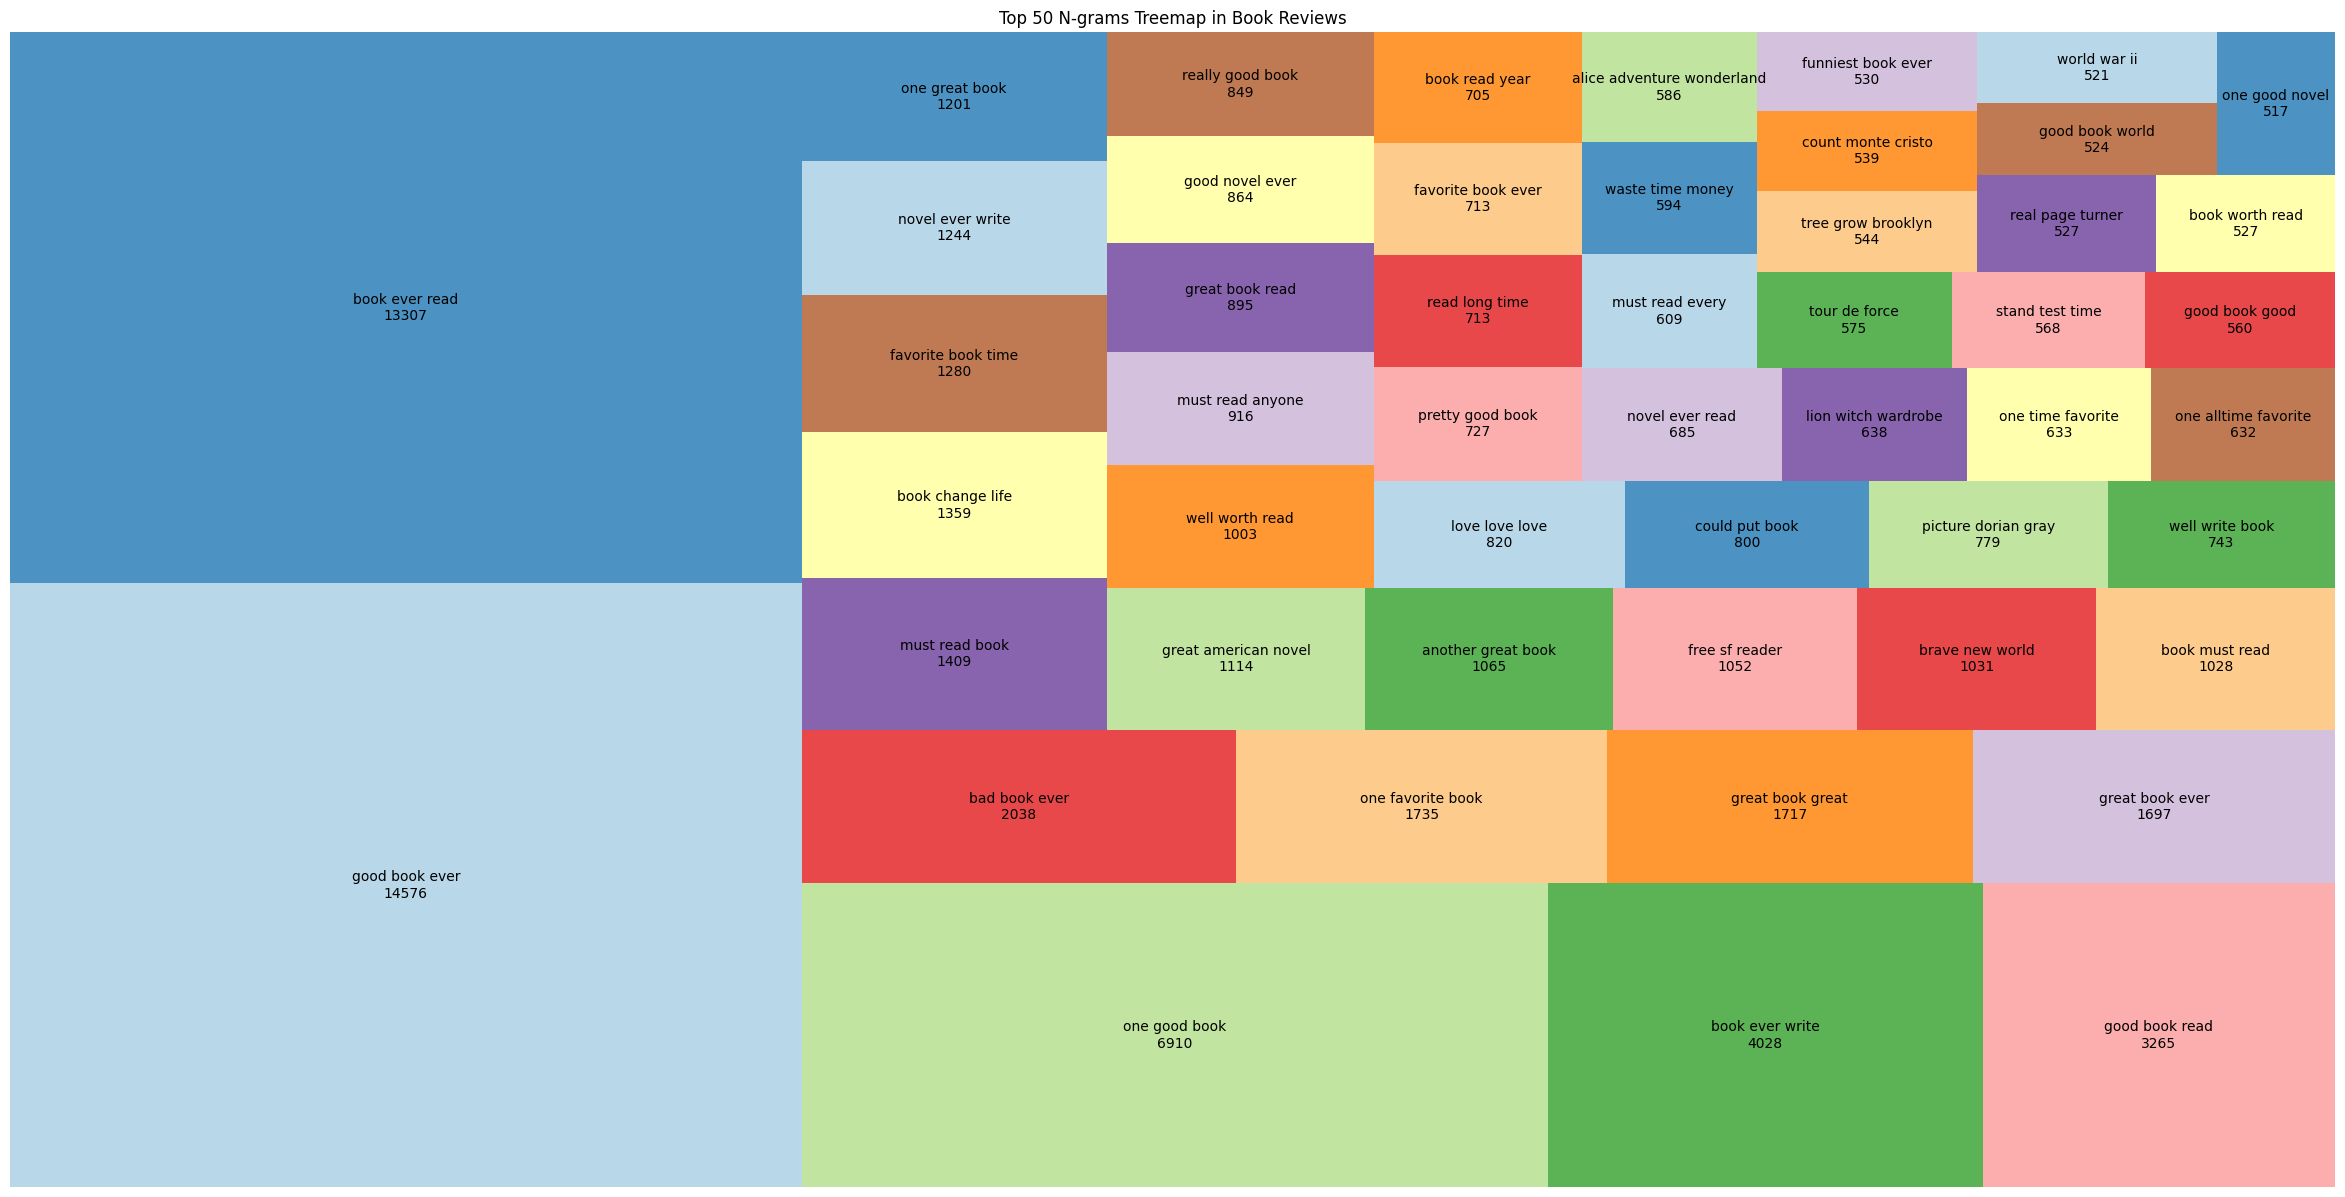

In [33]:
import matplotlib.pyplot as plt
import squarify

# Example list of top 50 N-grams with their frequencies
top_trigrams = [('good book ever', 14576), ('book ever read', 13307), ('one good book', 6910), ('book ever write', 4028), 
                ('good book read', 3265), ('bad book ever', 2038), ('one favorite book', 1735), ('great book great', 1717), 
                ('great book ever', 1697), ('must read book', 1409), ('book change life', 1359), ('favorite book time', 1280), 
                ('novel ever write', 1244), ('one great book', 1201), ('great american novel', 1114), ('another great book', 1065), 
                ('free sf reader', 1052), ('brave new world', 1031), ('book must read', 1028), ('well worth read', 1003), 
                ('must read anyone', 916), ('great book read', 895), ('good novel ever', 864), ('really good book', 849), 
                ('love love love', 820), ('could put book', 800), ('picture dorian gray', 779), ('well write book', 743), 
                ('pretty good book', 727), ('read long time', 713), ('favorite book ever', 713), ('book read year', 705), 
                ('novel ever read', 685), ('lion witch wardrobe', 638), ('one time favorite', 633), ('one alltime favorite', 632), 
                ('must read every', 609), ('waste time money', 594), ('alice adventure wonderland', 586), ('tour de force', 575), 
                ('stand test time', 568), ('good book good', 560), ('tree grow brooklyn', 544), ('count monte cristo', 539), 
                ('funniest book ever', 530), ('real page turner', 527), ('book worth read', 527), ('good book world', 524), 
                ('world war ii', 521), ('one good novel', 517)]

# Extract N-grams and their frequencies
ngrams_texts = [ngram for ngram, count in top_trigrams]
frequencies = [count for ngram, count in top_trigrams]

# Combine the N-gram text with its frequency for labeling
labels = [f'{ngram}\n{count}' for ngram, count in top_trigrams]

# Create a treemap
plt.figure(figsize=(30, 15))
squarify.plot(sizes=frequencies, label=labels, alpha=0.8, color=plt.cm.Paired.colors)

# Customize the plot
plt.title('Top 50 N-grams Treemap in Book Reviews')
plt.axis('off')  # Turn off the axes
plt.show()